**Part 0**

– Install required packages (run once if needed)

In [ ]:
!pip install scikit-learn pandas numpy matplotlib seaborn lazypredict shap


**Part 1**

– Import libraries and load the Boston Housing dataset from OpenML

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    HuberRegressor, SGDRegressor, PassiveAggressiveRegressor,
    PoissonRegressor, GammaRegressor, TweedieRegressor
)
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lazypredict.Supervised import LazyRegressor
import shap

sns.set(style="whitegrid", context="talk")

boston = fetch_openml(data_id=531, as_frame=True)
df = boston.frame

if 'MEDV' in df.columns:
    target_col = 'MEDV'
else:
    target_col = boston.target.name

print("Raw data shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Target column:", target_col)


Raw data shape: (506, 14)
Columns: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
Target column: MEDV


**Part 2**

– Detect and remove outliers using the IQR rule, then visualize the target before and after cleaning

After outlier removal shape: (288, 14)
Number of removed rows: 218


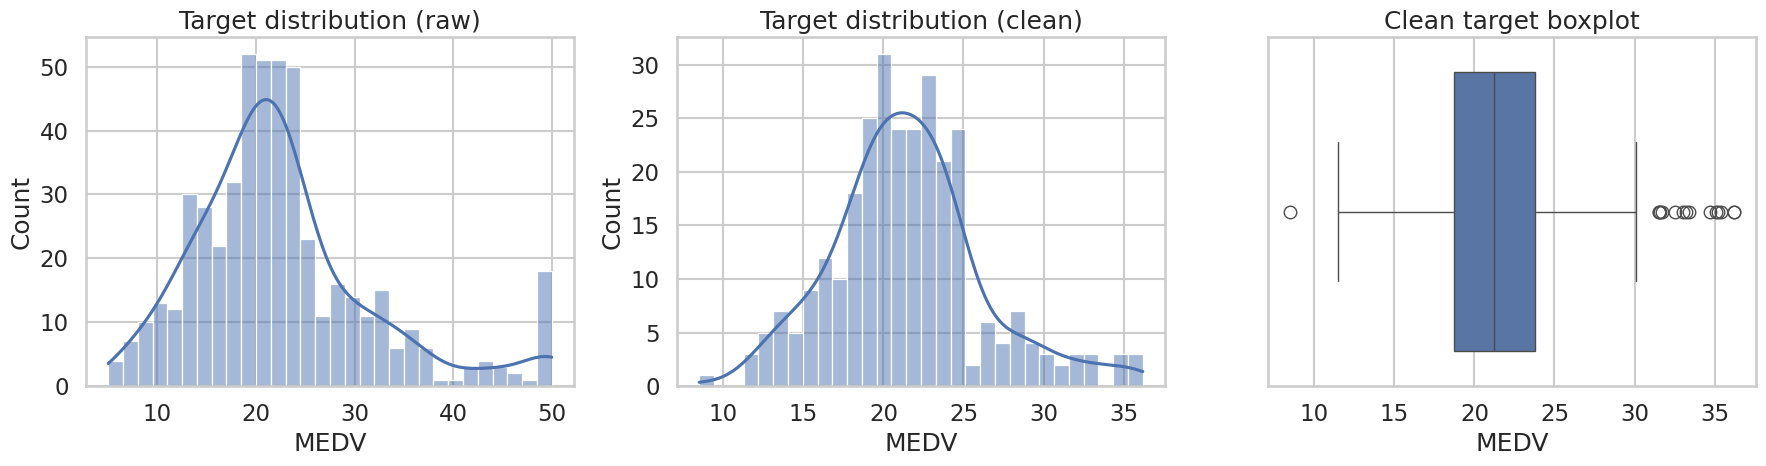

In [35]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

mask = ~(((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1))
df_clean = df[mask].copy()

print("After outlier removal shape:", df_clean.shape)
print("Number of removed rows:", df.shape[0] - df_clean.shape[0])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df[target_col], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Target distribution (raw)")
axes[0].set_xlabel("MEDV")

sns.histplot(df_clean[target_col], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Target distribution (clean)")
axes[1].set_xlabel("MEDV")

sns.boxplot(x=df_clean[target_col], ax=axes[2])
axes[2].set_title("Clean target boxplot")
axes[2].set_xlabel("MEDV")

plt.tight_layout()
plt.show()


**Part 3**

– Build X and y from the cleaned data, perform train/test split, and visualize target distribution for all/train/test

Train size: (230, 13)
Test size : (58, 13)


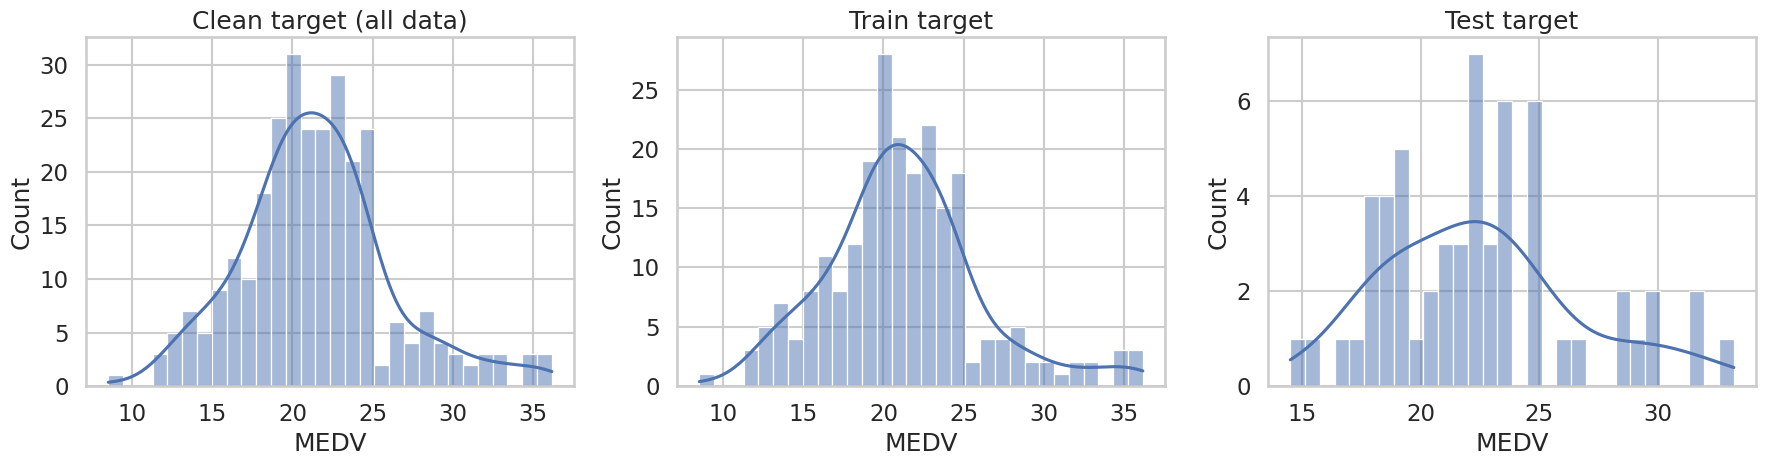

In [36]:
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col].astype(float)
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(y, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Clean target (all data)")
axes[0].set_xlabel("MEDV")

sns.histplot(y_train, bins=30, kde=True, ax=axes[1])
axes[1].set_title("Train target")
axes[1].set_xlabel("MEDV")

sns.histplot(y_test, bins=30, kde=True, ax=axes[2])
axes[2].set_title("Test target")
axes[2].set_xlabel("MEDV")

plt.tight_layout()
plt.show()


**Part 4**

– Run LazyPredict on standardized data to get a quick overview of many regressors

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lazy_reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

models_lazy, predictions_lazy = lazy_reg.fit(
    X_train_scaled, X_test_scaled, y_train, y_test
)

models_lazy_sorted = models_lazy.sort_values(by="RMSE")



  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 12
[LightGBM] [Info] Start training from score 21.238261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [40]:
print("Top models from LazyPredict (sorted by RMSE):")
models_lazy_sorted.head(15)

Top models from LazyPredict (sorted by RMSE):


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.67,0.74,2.08,0.09
GradientBoostingRegressor,0.67,0.74,2.09,0.61
HistGradientBoostingRegressor,0.66,0.74,2.10,0.26
ExtraTreesRegressor,0.66,0.74,2.10,0.62
XGBRegressor,0.66,0.74,2.12,0.57
RandomForestRegressor,0.61,0.70,2.27,0.61
BaggingRegressor,0.57,0.67,2.36,0.29
AdaBoostRegressor,0.57,0.67,2.38,0.39
Lars,0.49,0.60,2.60,0.02


**Part 5**

– Define only the assignment models, train them on cleaned data, and compute MAE, RMSE, and R²

In [41]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000),
    "SVR_RBF": SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1),
    "HuberRegressor": HuberRegressor(),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, max_depth=None, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, random_state=42
    ),
    "Gamma": GammaRegressor(alpha=1e-4, max_iter=1000),
    "Poisson": PoissonRegressor(alpha=1e-4, max_iter=1000),
    "Tweedie": TweedieRegressor(power=1.5, alpha=1e-4, max_iter=1000),
    "SGDRegressor": SGDRegressor(
        max_iter=1000, tol=1e-3, penalty='l2', random_state=42
    ),
    "PassiveAggressive": PassiveAggressiveRegressor(
        max_iter=1000, random_state=42
    )
}

pipelines = {
    name: make_pipeline(StandardScaler(), model)
    for name, model in models.items()
}

results = []
fitted_models = {}
predictions_test = {}

for name, pipe in pipelines.items():
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results.append({
            "model": name,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

        fitted_models[name] = pipe
        predictions_test[name] = y_pred

    except Exception as e:
        print(f"Model {name} failed with error: {e}")

results_df = pd.DataFrame(results).set_index("model")
results_df = results_df.sort_values(by="RMSE")
print("Assignment models performance (sorted by RMSE):")
print(results_df)


Assignment models performance (sorted by RMSE):
                   MAE  RMSE    R2
model                             
GradientBoosting  1.64  2.06  0.75
SVR_RBF           1.67  2.14  0.73
RandomForest      1.76  2.26  0.70
Gamma             1.98  2.56  0.61
Tweedie           1.98  2.56  0.61
Poisson           1.98  2.57  0.61
LinearRegression  2.05  2.60  0.60
Lasso             2.05  2.60  0.60
ElasticNet        2.05  2.60  0.60
Ridge             2.06  2.61  0.60
HuberRegressor    2.08  2.67  0.58
SGDRegressor      2.11  2.67  0.58
PassiveAggressive 3.62  4.36 -0.12


**Part 6**

– Plot horizontal barplots for RMSE and R² of the assignment models using Seaborn

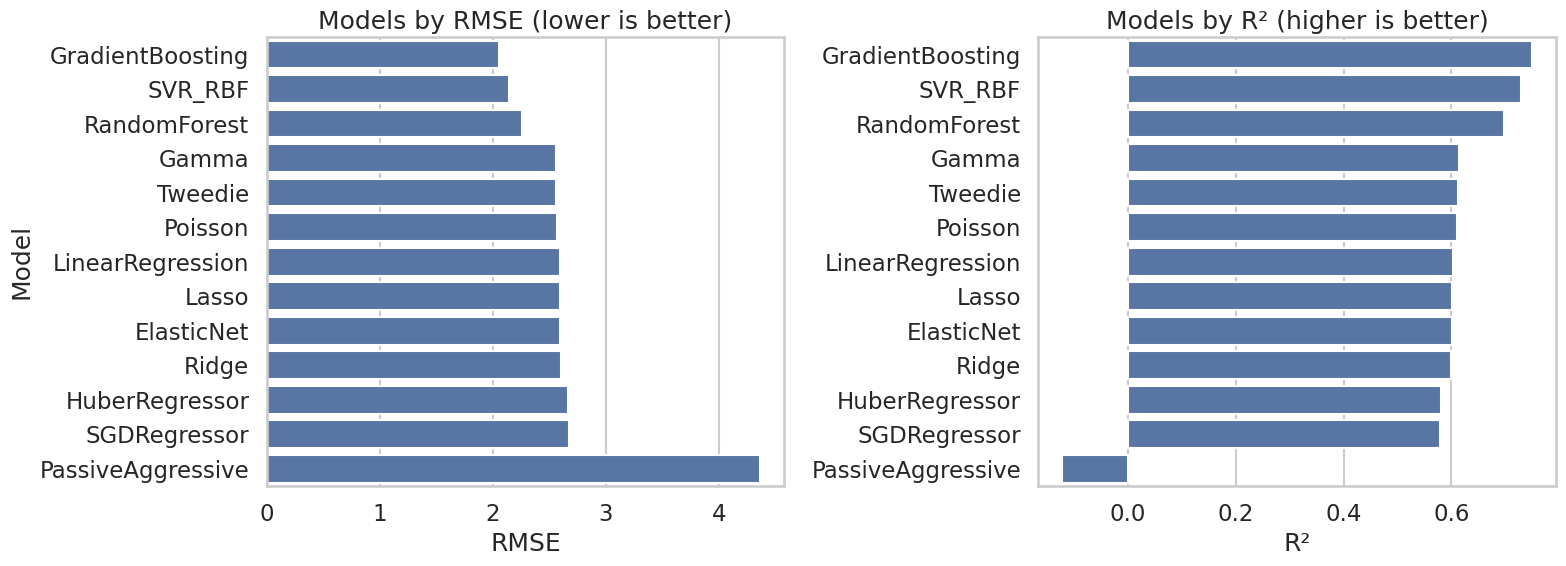

In [42]:
results_reset = results_df.reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    data=results_reset,
    x="RMSE", y="model",
    orient="h",
    ax=axes[0]
)
axes[0].set_title("Models by RMSE (lower is better)")
axes[0].set_xlabel("RMSE")
axes[0].set_ylabel("Model")

sns.barplot(
    data=results_reset,
    x="R2", y="model",
    orient="h",
    ax=axes[1]
)
axes[1].set_title("Models by R² (higher is better)")
axes[1].set_xlabel("R²")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


**Part 7**

– For each model, plot a scatter of true vs predicted with an ideal y=x line in a 3-column grid

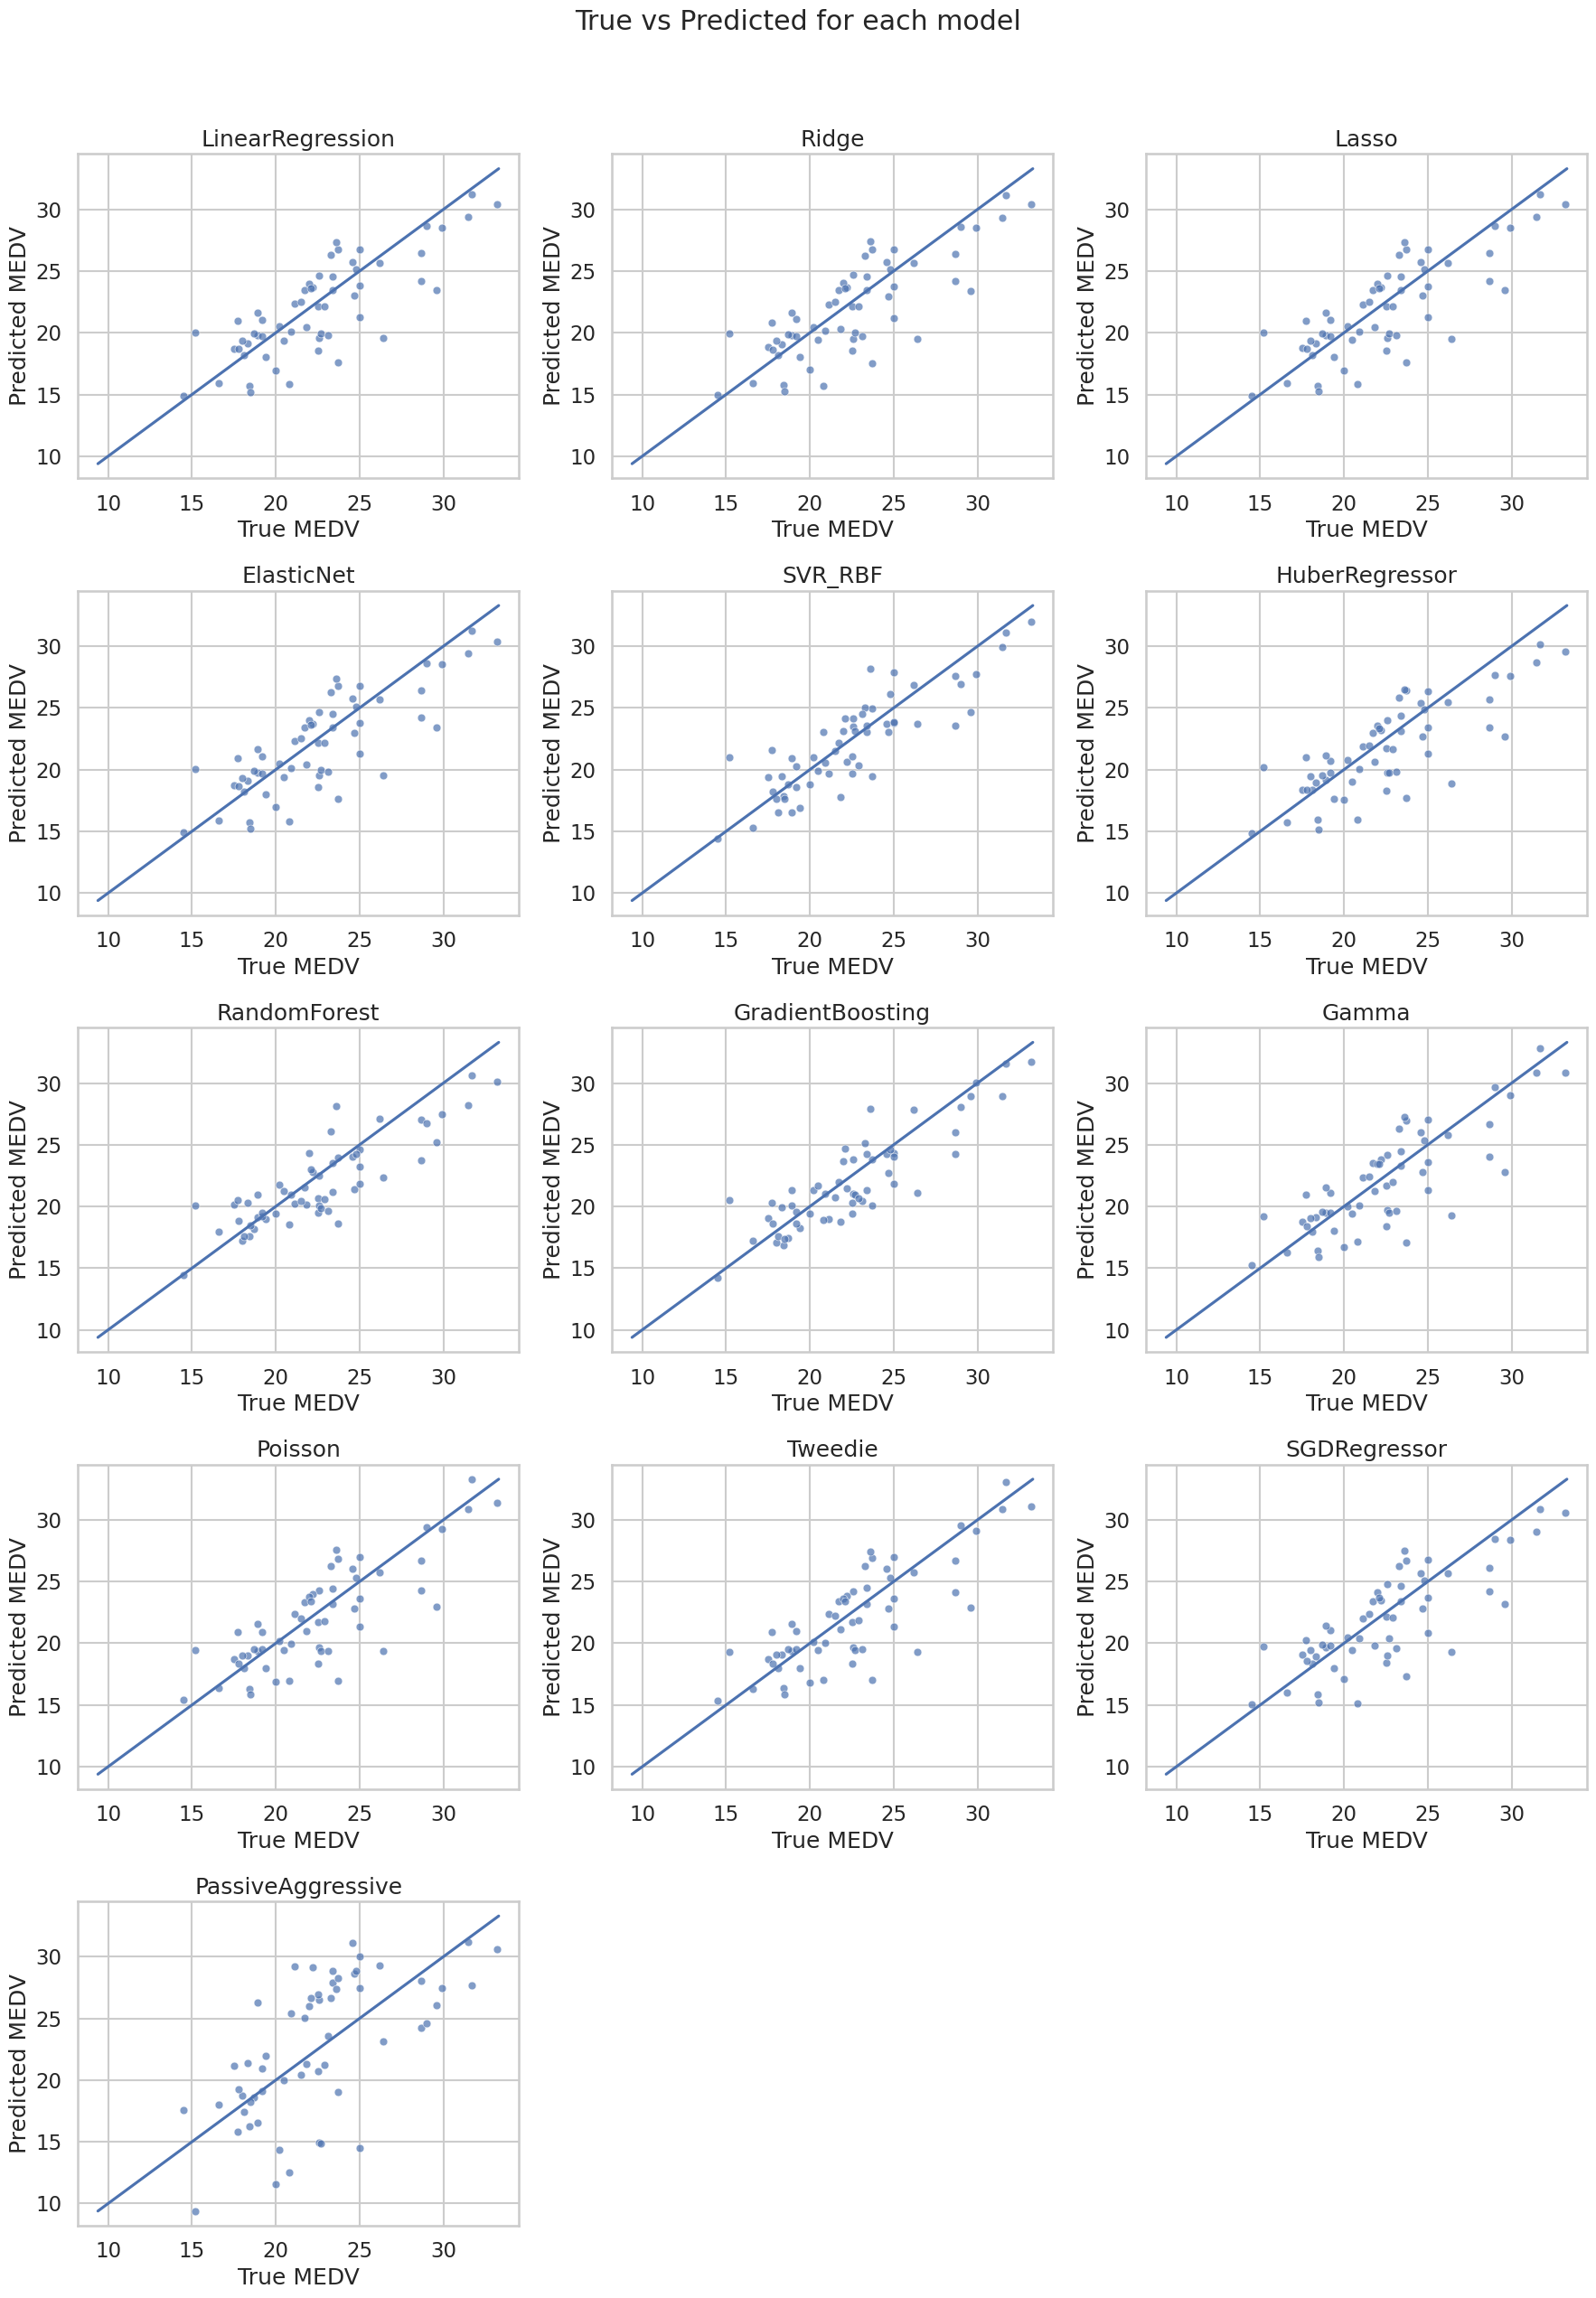

In [43]:
def plot_models_scatter_grid(y_true, predictions_dict, n_cols=3):
    model_names = list(predictions_dict.keys())
    n_models = len(model_names)
    n_rows = int(np.ceil(n_models / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(6 * n_cols, 5 * n_rows),
        squeeze=False
    )

    all_preds = np.concatenate([predictions_dict[m] for m in model_names])
    min_val = min(y_true.min(), all_preds.min())
    max_val = max(y_true.max(), all_preds.max())

    for idx, name in enumerate(model_names):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]

        y_pred = predictions_dict[name]

        sns.scatterplot(
            x=y_true, y=y_pred,
            ax=ax, s=40, alpha=0.7
        )

        sns.lineplot(
            x=[min_val, max_val],
            y=[min_val, max_val],
            ax=ax
        )

        ax.set_title(name)
        ax.set_xlabel("True MEDV")
        ax.set_ylabel("Predicted MEDV")

    for idx in range(len(model_names), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis("off")

    plt.suptitle("True vs Predicted for each model", y=1.02)
    plt.tight_layout()
    plt.show()


plot_models_scatter_grid(y_test.values, predictions_test, n_cols=3)


**Part 8**

– Select the best model by RMSE and create three diagnostic plots in one row (true vs predicted, residuals vs predicted, residual histogram)

Best assignment model based on RMSE: GradientBoosting


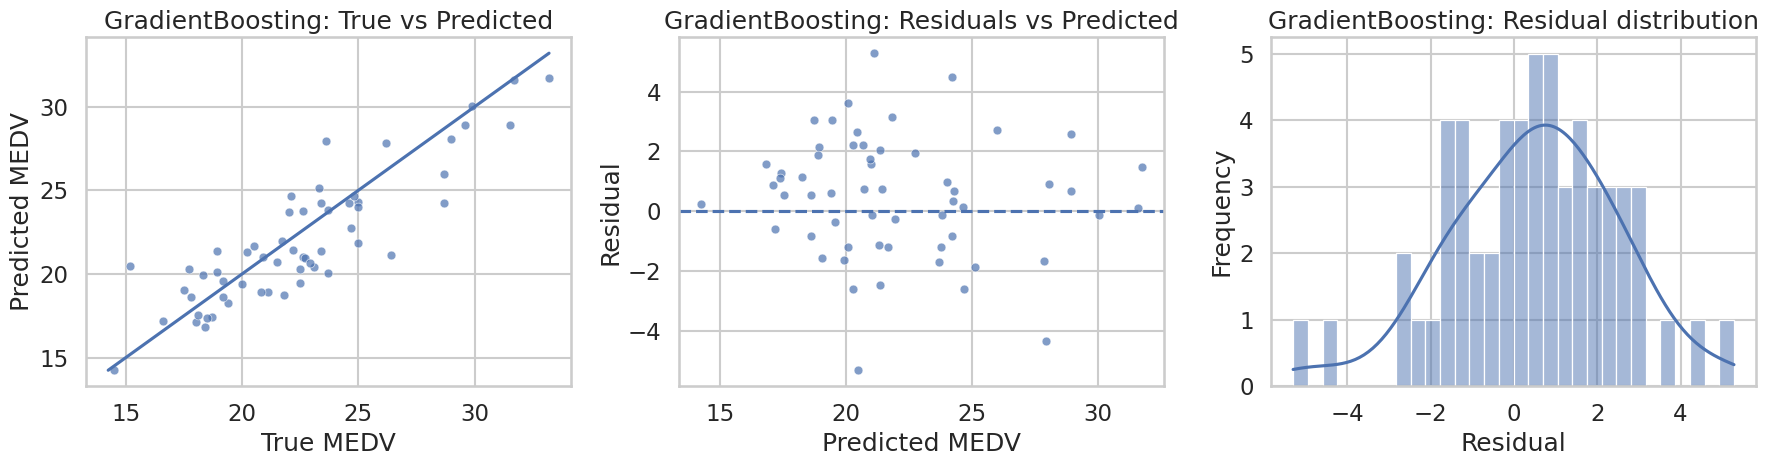

In [44]:
best_model_name = results_df.index[0]
print("Best assignment model based on RMSE:", best_model_name)

best_model = fitted_models[best_model_name]
y_pred_test_best = predictions_test[best_model_name]

residuals = y_test - y_pred_test_best

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

min_val = min(y_test.min(), y_pred_test_best.min())
max_val = max(y_test.max(), y_pred_test_best.max())

sns.scatterplot(x=y_test, y=y_pred_test_best, s=40, alpha=0.7, ax=axes[0])
sns.lineplot(x=[min_val, max_val], y=[min_val, max_val], ax=axes[0])
axes[0].set_title(f"{best_model_name}: True vs Predicted")
axes[0].set_xlabel("True MEDV")
axes[0].set_ylabel("Predicted MEDV")

sns.scatterplot(x=y_pred_test_best, y=residuals, s=40, alpha=0.7, ax=axes[1])
axes[1].axhline(0, linestyle="--")
axes[1].set_title(f"{best_model_name}: Residuals vs Predicted")
axes[1].set_xlabel("Predicted MEDV")
axes[1].set_ylabel("Residual")

sns.histplot(residuals, bins=30, kde=True, ax=axes[2])
axes[2].set_title(f"{best_model_name}: Residual distribution")
axes[2].set_xlabel("Residual")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


**Part 9**

– Compute generic feature importance for the best model and visualize it as a horizontal barplot

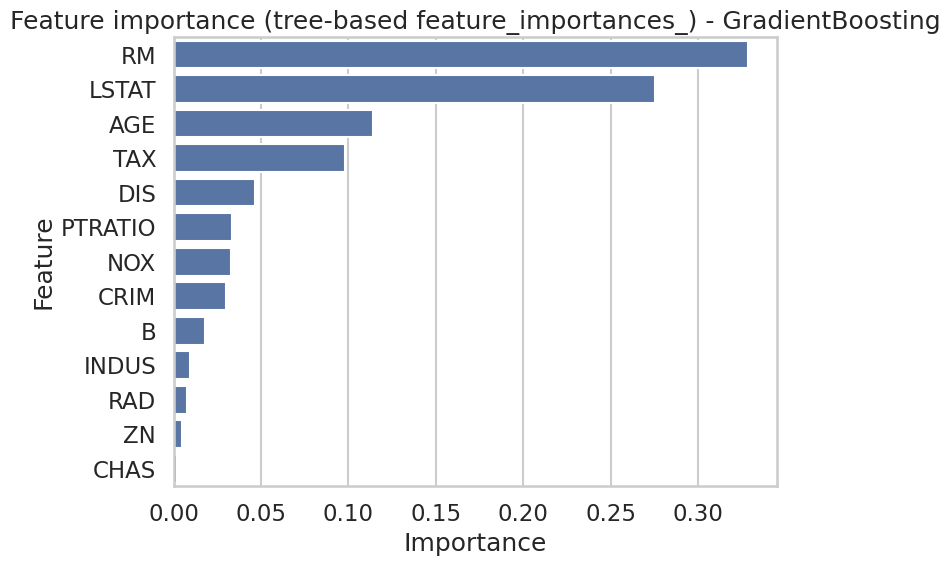

    feature  importance
0        RM        0.33
1     LSTAT        0.28
2       AGE        0.11
3       TAX        0.10
4       DIS        0.05
5   PTRATIO        0.03
6       NOX        0.03
7      CRIM        0.03
8         B        0.02
9     INDUS        0.01
10      RAD        0.01
11       ZN        0.00
12     CHAS        0.00


In [45]:
from sklearn.inspection import permutation_importance

def plot_feature_importance_generic(trained_pipeline, X_data, y_data, feature_names,
                                    n_repeats=30, random_state=42):
    if hasattr(trained_pipeline, "named_steps"):
        est = list(trained_pipeline.named_steps.values())[-1]
    else:
        est = trained_pipeline

    if hasattr(est, "feature_importances_"):
        importances = est.feature_importances_
        method = "tree-based feature_importances_"
    elif hasattr(est, "coef_"):
        coefs = est.coef_
        if isinstance(coefs, np.ndarray) and coefs.ndim > 1:
            coefs = coefs.ravel()
        importances = np.abs(coefs)
        method = "absolute coefficients"
    else:
        result = permutation_importance(
            trained_pipeline, X_data, y_data,
            n_repeats=n_repeats, random_state=random_state, n_jobs=-1
        )
        importances = result.importances_mean
        method = "permutation importance"

    indices = np.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    fi_df = pd.DataFrame({
        "feature": sorted_features,
        "importance": sorted_importances
    })

    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=fi_df,
        x="importance", y="feature",
        orient="h"
    )
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Feature importance ({method}) - {best_model_name}")
    plt.tight_layout()
    plt.show()

    return fi_df

fi_df = plot_feature_importance_generic(
    best_model, X_train, y_train, feature_names
)
print(fi_df)


**Part 10**

– Run SHAP to compute global and local explanations (summary plot + several force plots for individual samples)

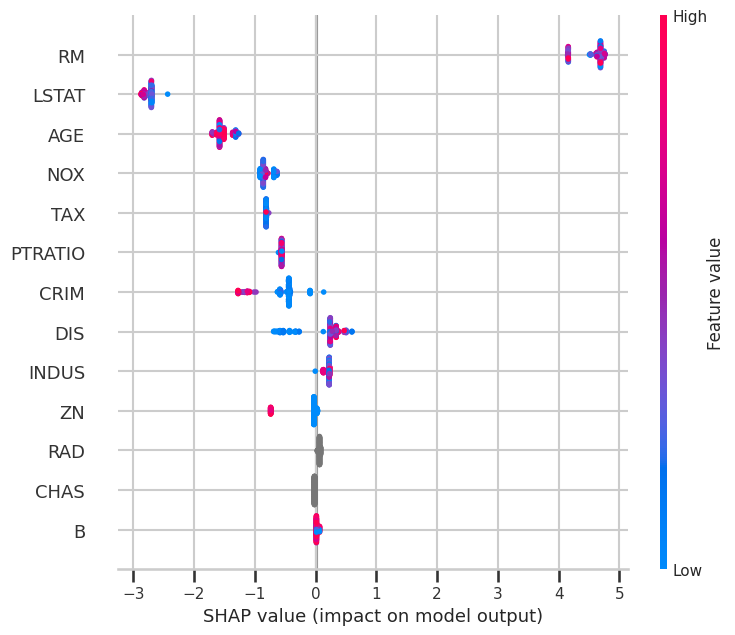

In [46]:
if hasattr(best_model, "named_steps"):
    final_est = list(best_model.named_steps.values())[-1]
else:
    final_est = best_model

X_train_sample = X_train.sample(
    n=min(200, len(X_train)),
    random_state=42
)

tree_based_types = (
    RandomForestRegressor,
    GradientBoostingRegressor
)

if isinstance(final_est, tree_based_types):
    explainer = shap.TreeExplainer(final_est)
    shap_values = explainer.shap_values(X_train_sample)
elif hasattr(final_est, "coef_"):
    explainer = shap.LinearExplainer(final_est, X_train)
    shap_values = explainer.shap_values(X_train_sample)
else:
    explainer = None
    shap_values = None
    print(f"SHAP not configured for model type: {type(final_est)}")

if shap_values is not None:
    shap.summary_plot(shap_values, X_train_sample, feature_names=feature_names)



SHAP force plot for sample index 175


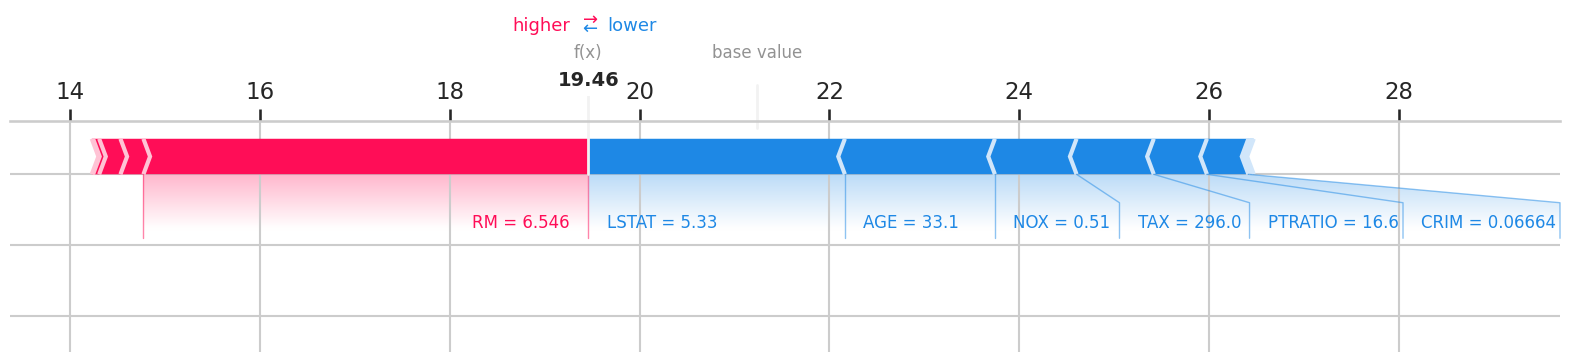


SHAP force plot for sample index 222


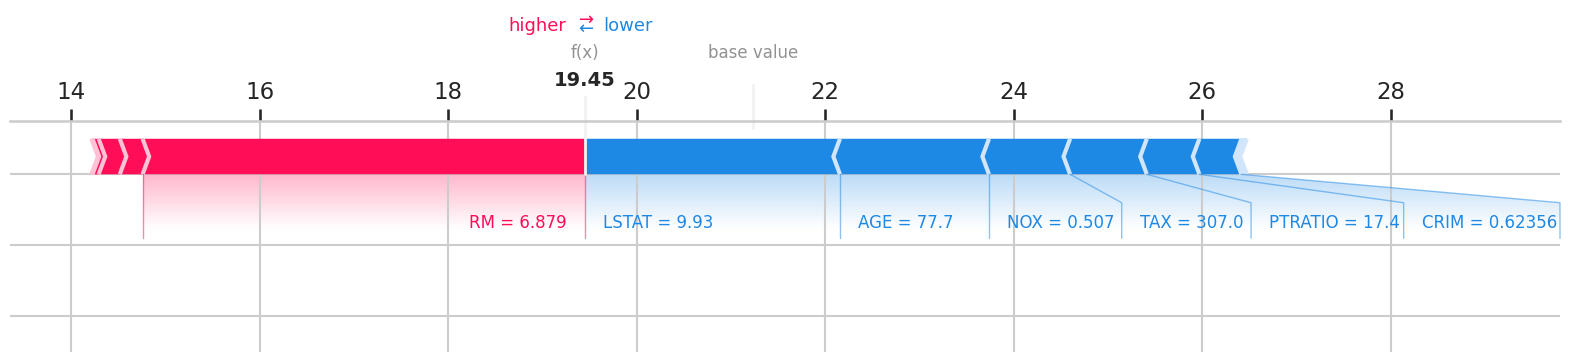


SHAP force plot for sample index 103


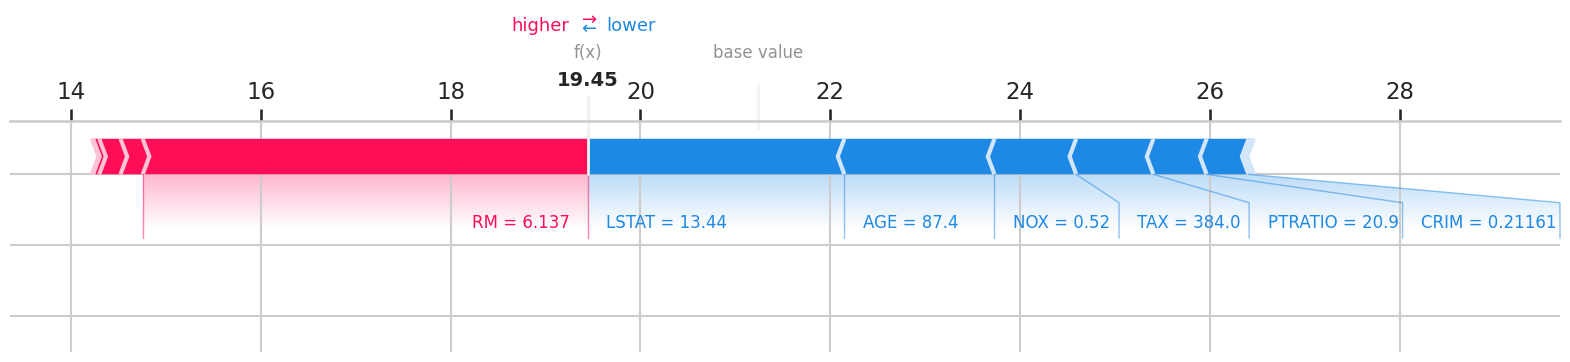


SHAP force plot for sample index 361


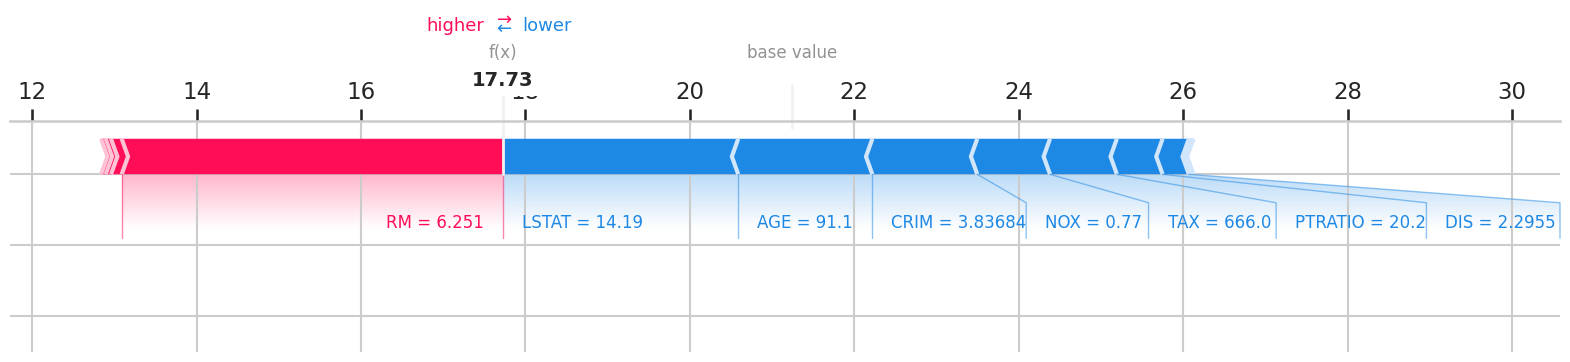


SHAP force plot for sample index 173


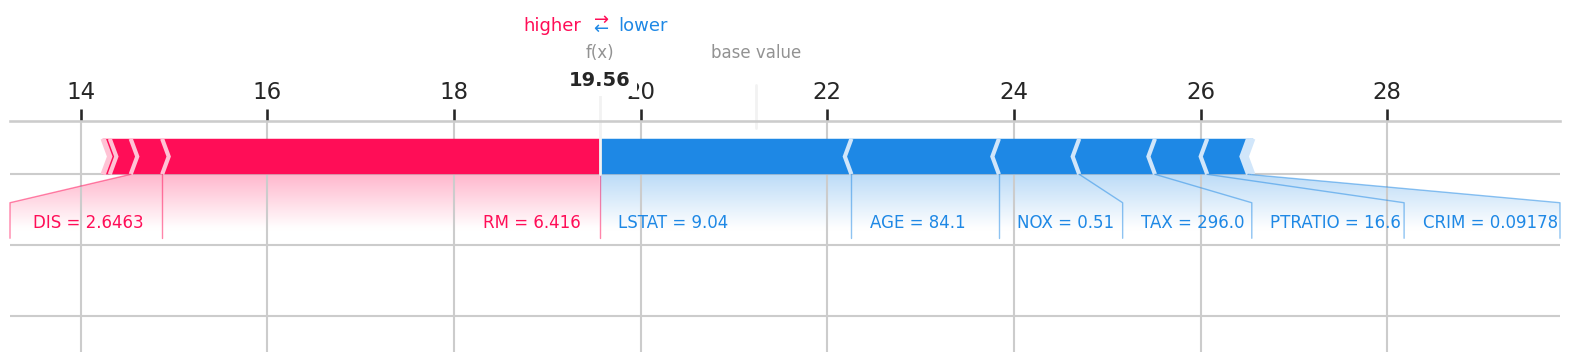


SHAP force plot for sample index 484


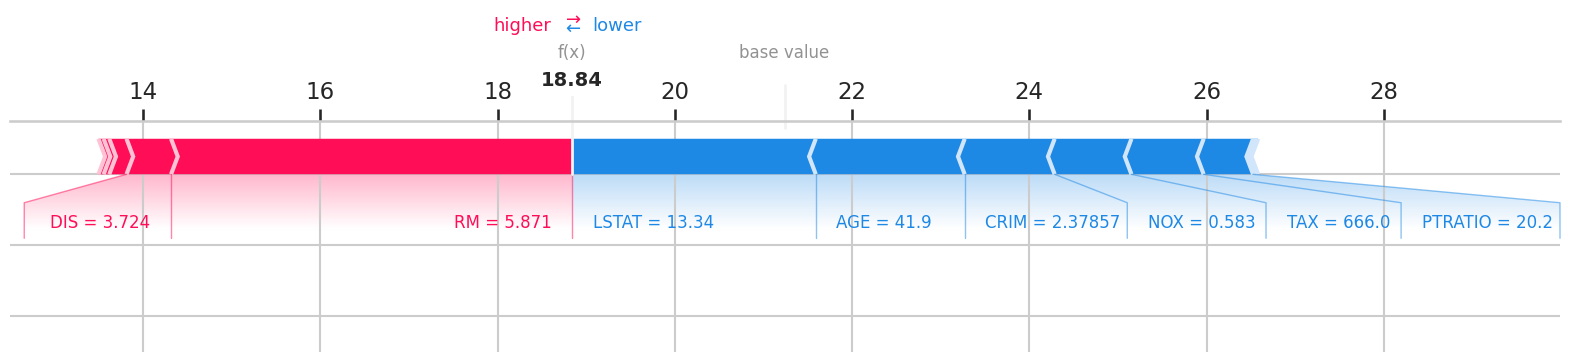


SHAP force plot for sample index 244


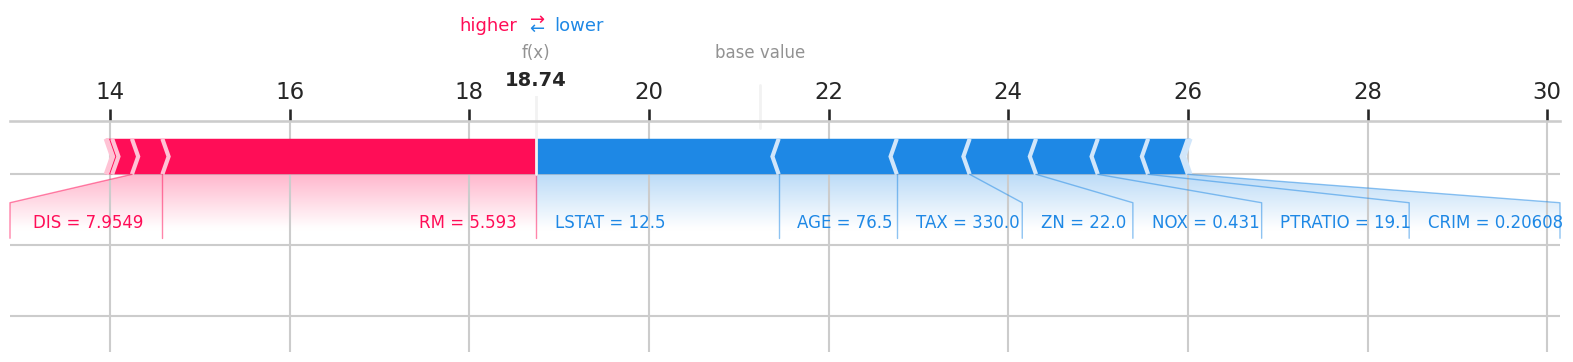


SHAP force plot for sample index 42


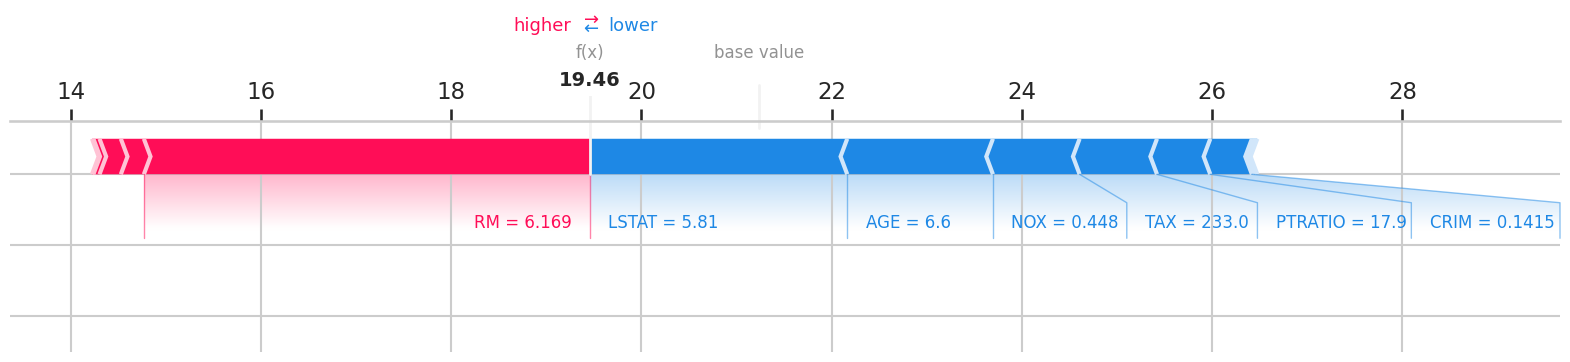


SHAP force plot for sample index 390


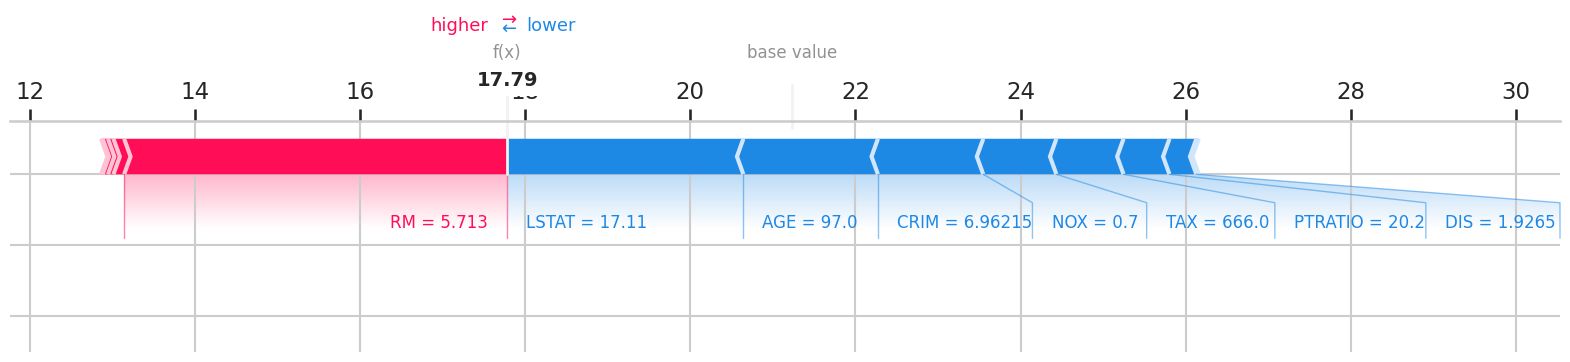


SHAP force plot for sample index 270


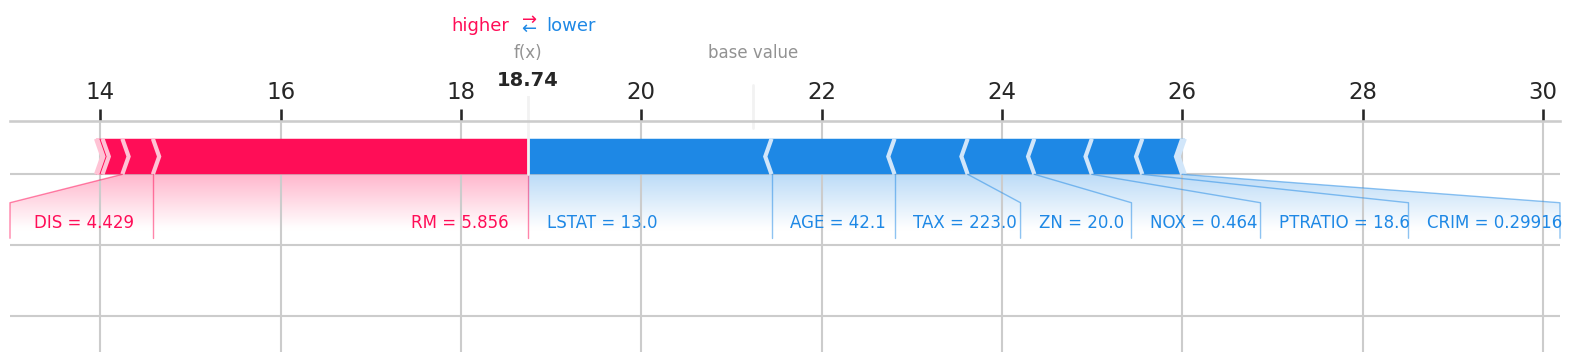

In [49]:
if shap_values is not None:
    shap_vals = np.array(shap_values)

    n_force = 10
    sample_indices = np.random.choice(len(X_train_sample), size=min(n_force, len(X_train_sample)), replace=False)

    for idx in sample_indices:
        x_sample = X_train_sample.iloc[idx, :]
        sv_sample = shap_vals[idx]

        print(f"\nSHAP force plot for sample index {X_train_sample.index[idx]}")

        shap.force_plot(
            explainer.expected_value,
            sv_sample,
            x_sample,
            matplotlib=True
        )


**Part 11**

– Perform manual K-Fold cross-validation (K=5) for the best model and plot fold-wise metrics

Best model (assignment set): GradientBoosting
MAE:  mean=1.628,  std=0.075
RMSE: mean=2.269, std=0.211
R2:   mean=0.751,   std=0.061


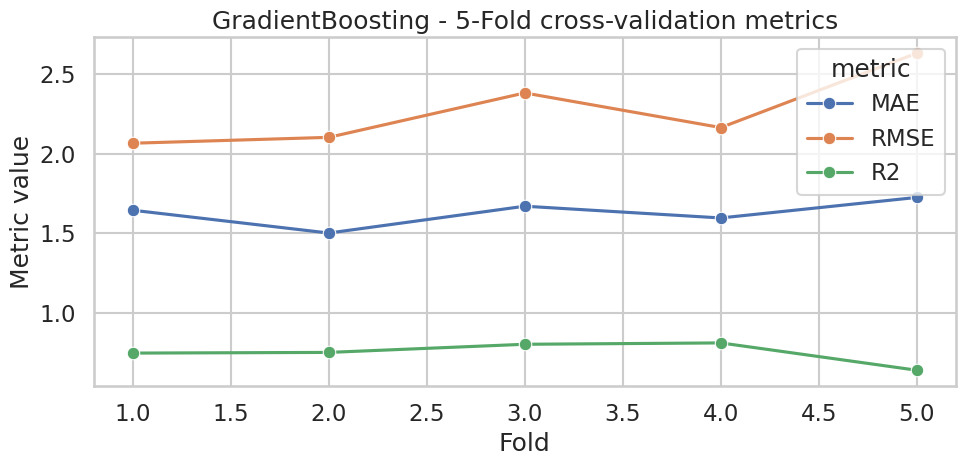

In [50]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cv_mae_list = []
cv_rmse_list = []
cv_r2_list = []

for train_idx, test_idx in kf.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    best_model.fit(X_tr, y_tr)
    y_pred_cv = best_model.predict(X_te)

    mae = mean_absolute_error(y_te, y_pred_cv)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred_cv))
    r2 = r2_score(y_te, y_pred_cv)

    cv_mae_list.append(mae)
    cv_rmse_list.append(rmse)
    cv_r2_list.append(r2)

print(f"Best model (assignment set): {best_model_name}")
print(f"MAE:  mean={np.mean(cv_mae_list):.3f},  std={np.std(cv_mae_list):.3f}")
print(f"RMSE: mean={np.mean(cv_rmse_list):.3f}, std={np.std(cv_rmse_list):.3f}")
print(f"R2:   mean={np.mean(cv_r2_list):.3f},   std={np.std(cv_r2_list):.3f}")

cv_df = pd.DataFrame({
    "fold": list(range(1, k + 1)),
    "MAE": cv_mae_list,
    "RMSE": cv_rmse_list,
    "R2": cv_r2_list
})

cv_melt = cv_df.melt(id_vars="fold", value_vars=["MAE", "RMSE", "R2"],
                     var_name="metric", value_name="value")

plt.figure(figsize=(10, 5))
sns.lineplot(data=cv_melt, x="fold", y="value", hue="metric", marker="o")
plt.title(f"{best_model_name} - {k}-Fold cross-validation metrics")
plt.xlabel("Fold")
plt.ylabel("Metric value")
plt.tight_layout()
plt.show()
